# Load Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from myfunctions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import joblib

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Load data set
data_full = pd.read_json('fake_news.json', lines=True)
data_full = data_full.drop(columns=['article_link']) # remove link column
df_train_f, df_test = split_dataframe(data_full, test_size=0.25, seed=1509)
df_train, df_validate = split_dataframe(df_train_f, test_size=0.2, seed=1309)

# Proportion of each subsets
list_label = df_train['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TRAINING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_validate['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== VALIDATING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_test['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TESTING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

===== TRAINING SAMPLES =====
Total Sample: 17171
Sarcastic: 8180 (47.64%)
Not Sarcastic: 8991 (52.36%)
===== VALIDATING SAMPLES =====
Total Sample: 4293
Sarcastic: 2045 (47.64%)
Not Sarcastic: 2248 (52.36%)
===== TESTING SAMPLES =====
Total Sample: 7155
Sarcastic: 3409 (47.65%)
Not Sarcastic: 3746 (52.35%)


In [4]:
# Preprocess headline: discard symbol and lemmatise titles

data_train = df_train
data_train['headline'] = data_train.headline.apply(lambda row: row.lower()) # Lower headline
data_train['headline_s1'] = data_train.headline.apply(lambda row: remove_symbol(row)) # Remove symbol
data_train['headline_s2'] = data_train.headline_s1.apply(lambda row: lemmatize_word(row, 'v')) # Lemmatise verb
data_train['headline_s2'] = data_train.headline_s2.apply(lambda row: lemmatize_word(row, 'n')) # Lemmatise noun
#data_train = data_train.drop(columns=['headline', 'headline_s1'])

data_train_f = df_train_f
data_train_f['headline'] = data_train_f.headline.apply(lambda row: row.lower())
data_train_f['headline_s1'] = data_train_f.headline.apply(lambda row: remove_symbol(row))
data_train_f['headline_s2'] = data_train_f.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_train_f['headline_s2'] = data_train_f.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

data_val = df_validate
data_val['headline'] = data_val.headline.apply(lambda row: row.lower())
data_val['headline_s1'] = data_val.headline.apply(lambda row: remove_symbol(row))
data_val['headline_s2'] = data_val.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_val['headline_s2'] = data_val.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
#data_val = data_val.drop(columns=['headline', 'headline_s1'])

data_test = df_test
data_test['headline'] = data_test.headline.apply(lambda row: row.lower())
data_test['headline_s1'] = data_test.headline.apply(lambda row: remove_symbol(row))
data_test['headline_s2'] = data_test.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_test['headline_s2'] = data_test.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

In [5]:
# remove stopwords
data_train_rmsw = data_train.copy()
data_train_rmsw['headline_s3'] = data_train_rmsw.headline_s1.apply(lambda row: remove_stop_words(row))
#data_train_rmsw = data_train_rmsw.drop(columns=['headline_s2'])

data_val_rmsw = data_val.copy()
data_val_rmsw['headline_s3'] = data_val_rmsw.headline_s1.apply(lambda row: remove_stop_words(row))
#data_val_rmsw = data_val_rmsw.drop(columns=['headline_s2'])

# Dictionary summary
Count the unique words in the training, validating, testing dictionary

In [5]:
all_string_train = data_train.headline_s1.tolist()
all_string_in_one = ' '.join(all_string_train)
train_words, train_count_words = most_common_words(all_string_in_one, numb_words=-1)

all_string_val = data_val.headline_s1.tolist()
all_string_in_one = ' '.join(all_string_val)
val_words, val_count_words = most_common_words(all_string_in_one, numb_words=-1)

all_string_test = data_test.headline_s1.tolist()
all_string_in_one = ' '.join(all_string_test)
test_words, test_count_words = most_common_words(all_string_in_one, numb_words=-1)


In [10]:
len([x for x in val_words if x not in train_words])

2651

In [5]:
all_string_train = data_train.headline_s2.tolist()
all_string_in_one = ' '.join(all_string_train)
train_words, train_count_words = most_common_words(all_string_in_one, numb_words=-1)

all_string_val = data_val.headline_s2.tolist()
all_string_in_one = ' '.join(all_string_val)
val_words, val_count_words = most_common_words(all_string_in_one, numb_words=-1)

all_string_test = data_test.headline_s2.tolist()
all_string_in_one = ' '.join(all_string_test)
test_words, test_count_words = most_common_words(all_string_in_one, numb_words=-1)


In [8]:
len(test_words)#len([x for x in test_words if x not in train_words])

11570

# Common Words
calculate the occurence of words in the training dataset and find the most frequent words to plot

In [6]:
# Check whether a sentence contain a word or not
def sent_contains_word(sent, word):
    if word in word_tokenize(sent):
        return 1
    else:
        return 0

In [7]:
# Split into distinct real and sarcastic headlines
data_train_real = data_train[data_train.is_sarcastic==0]
data_train_sarcastic = data_train[data_train.is_sarcastic==1]

all_string_real = data_train_real.headline.tolist()
all_string_in_one = ' '.join(all_string_real)
list_common_words_real, count_words_real = most_common_words(all_string_in_one, numb_words=-1)

all_string_sarcastic = data_train_sarcastic.headline.tolist()
all_string_in_one = ' '.join(all_string_sarcastic)
list_common_words_sarcastic, count_words_sarcastic = most_common_words(all_string_in_one, numb_words=-1)

In [10]:
## VALIDATE SET
# data_val_real = data_val[data_val.is_sarcastic==0]
# data_val_sarcastic = data_val[data_val.is_sarcastic==1]

# all_string_real = data_val_real.headline.tolist()
# all_string_in_one = ' '.join(all_string_real)
# list_common_words_real_val, count_words_real_val = most_common_words(all_string_in_one, numb_words=-1)

# all_string_sarcastic = data_val_sarcastic.headline.tolist()
# all_string_in_one = ' '.join(all_string_sarcastic)
# list_common_words_sarcastic_val, count_words_sarcastic_val = most_common_words(all_string_in_one, numb_words=-1)

# sum(count_words_real_val), sum(count_words_sarcastic_val)

In [11]:
## TESTING SET
# data_test_real = data_test[data_test.is_sarcastic==0]
# data_test_sarcastic = data_test[data_test.is_sarcastic==1]

# all_string_real = data_test_real.headline.tolist()
# all_string_in_one = ' '.join(all_string_real)
# list_common_words_real_test, count_words_real_test = most_common_words(all_string_in_one, numb_words=-1)

# all_string_sarcastic = data_test_sarcastic.headline.tolist()
# all_string_in_one = ' '.join(all_string_sarcastic)
# list_common_words_sarcastic_test, count_words_sarcastic_test = most_common_words(all_string_in_one, numb_words=-1)

# sum(count_words_real_test), sum(count_words_sarcastic_test)

In [8]:
# count the percentage of sentences contain list of given words
count_sent_pc_real = [sum([1 if sent_contains_word(x, y) else 0 for x in all_string_real]) for y in list_common_words_real[0:20]]
count_sent_pc_sarcastic = [sum([1 if sent_contains_word(x, y) else 0 for x in all_string_sarcastic]) for y in list_common_words_sarcastic[0:20]]

count_sent_pc_real = [x / len(all_string_real) for x in count_sent_pc_real]
count_sent_pc_sarcastic = [x / len(all_string_sarcastic) for x in count_sent_pc_sarcastic]

In [9]:
# Create dataframe to plot
cw_r = pd.DataFrame(data={'common_words': list_common_words_real[0:20], 
                          'count': count_words_real[0:20], 
                          'count_pc': [x/sum(count_words_real) for x in count_words_real[0:20]],
                          'count_sent_pc': count_sent_pc_real})

cw_s = pd.DataFrame(data={'common_words': list_common_words_sarcastic[0:20], 
                          'count': count_words_sarcastic[0:20], 
                          'count_pc': [x/sum(count_words_sarcastic) for x in count_words_sarcastic[0:20]],
                          'count_sent_pc': count_sent_pc_sarcastic})

In [13]:
cw_r.head()

,common_words,count,count_pc,count_sent_pc
0,the,2732,0.030857,0.266044
1,to,2471,0.027909,0.253031
2,of,1532,0.017303,0.162941
3,a,1526,0.017236,0.160383
4,in,1462,0.016513,0.158047


In [14]:
cw_s.head()

,common_words,count,count_pc,count_sent_pc
0,to,2935,0.034988,0.321394
1,of,2242,0.026727,0.253545
2,in,1245,0.014842,0.147311
3,for,1025,0.012219,0.122005
4,on,786,0.009370,0.093888


In [15]:
top_real_not_stop = [x for x in list_common_words_real[0:20] if x not in list_stopwords]
top_sarcastic_not_stop = [x for x in list_common_words_sarcastic[0:20] if x not in list_stopwords]

print(top_real_not_stop)
print(top_sarcastic_not_stop)

['trump', 'new']
['man', 'new', 'area']


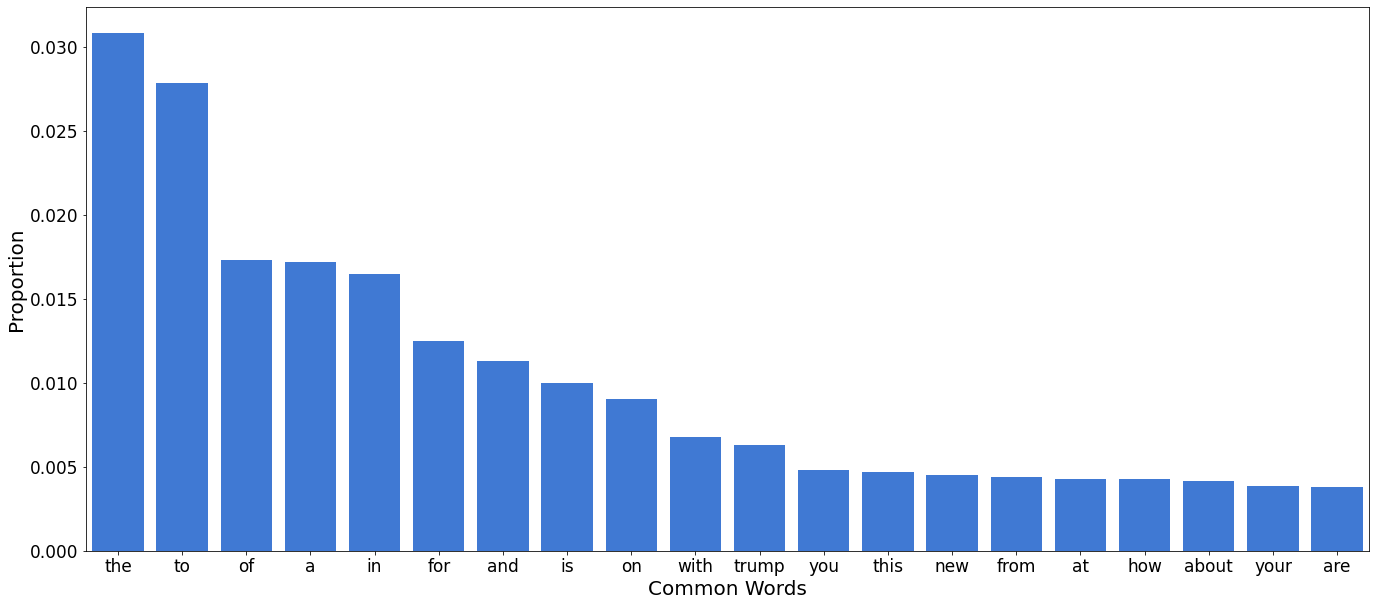

In [17]:
plt.figure(figsize=(23,10))

sns.barplot(x = 'common_words',
            y = 'count_pc',
            data = cw_r,
            color="#2873eb")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_real_count_pc.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


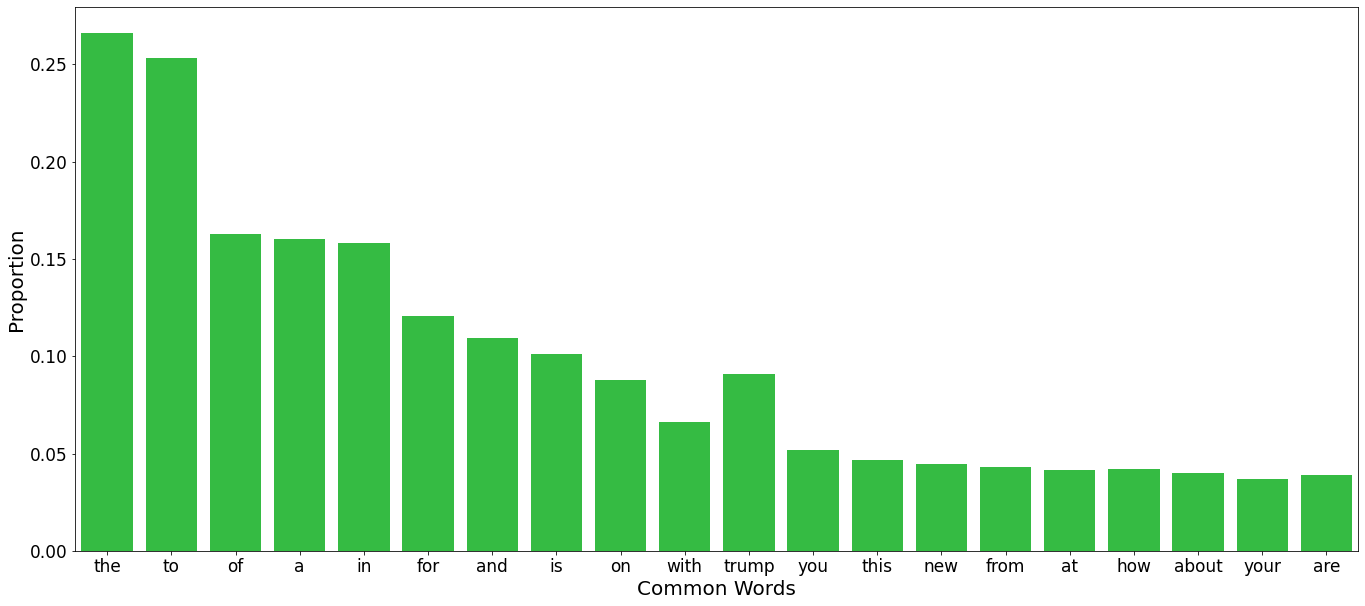

In [18]:
plt.figure(figsize=(23,10))

sns.barplot(x = 'common_words',
            y = 'count_sent_pc',
            data = cw_r,
            color="#1fd131")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_real_count_sent_pc.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


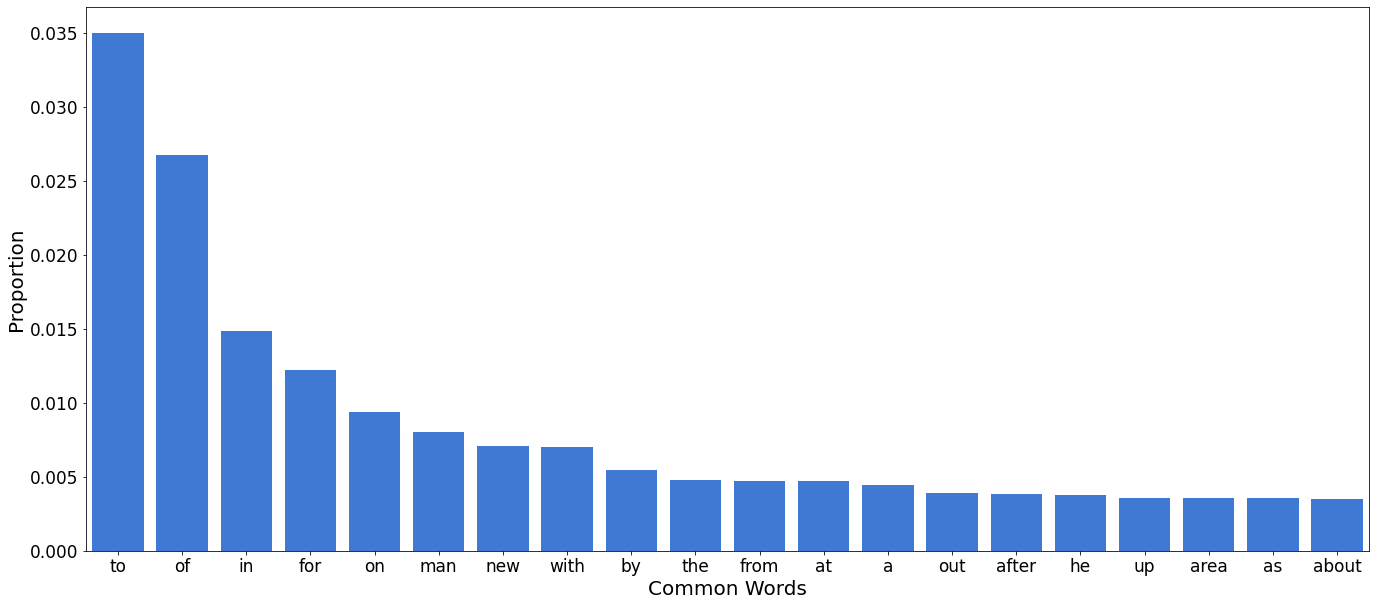

In [19]:
plt.figure(figsize=(23,10))

sns.barplot(x = 'common_words',
            y = 'count_pc',
            data = cw_s,
            color="#2873eb")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_sarcastic_count_pc.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


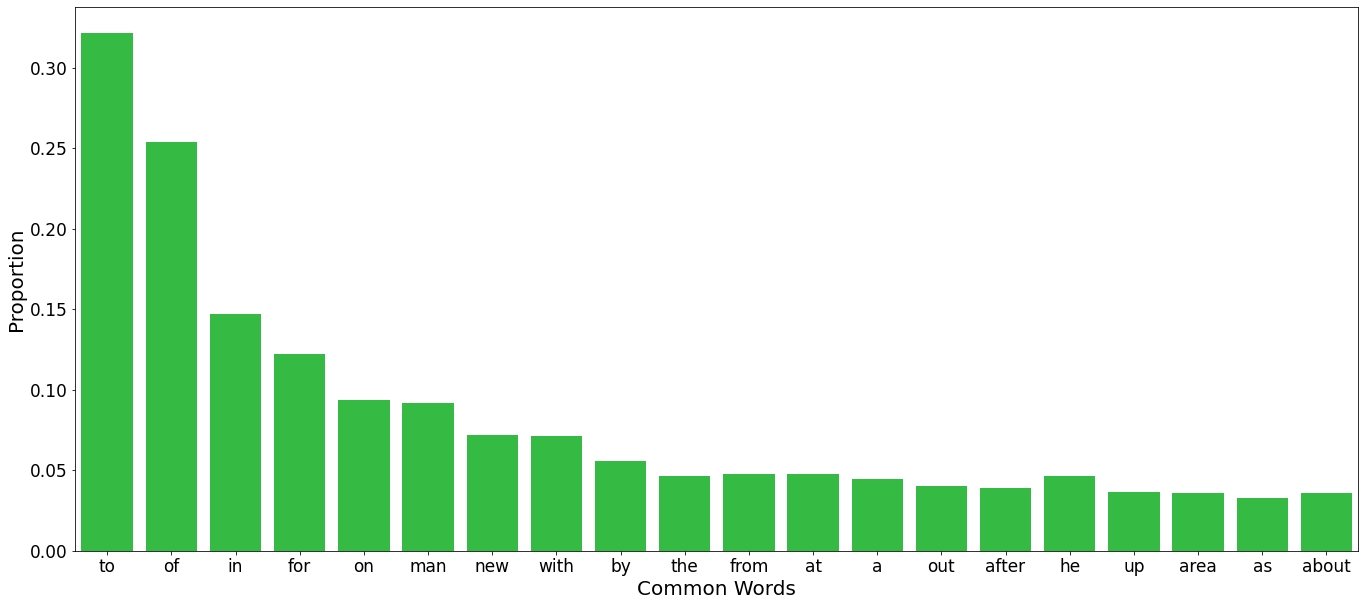

In [20]:
plt.figure(figsize=(23,10))

sns.barplot(x = 'common_words',
            y = 'count_sent_pc',
            data = cw_s,
            color="#1fd131")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_sarcastic_count_sent_pc.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


# Common Words without Stopwords
Remove the stop words and calculate the frequence of words again

In [22]:
# Split data into real and sarcastic headline
data_train_real = data_train_rmsw[data_train_rmsw.is_sarcastic==0]
data_train_sarcastic = data_train_rmsw[data_train_rmsw.is_sarcastic==1]

all_string_real = data_train_real.headline_s3.tolist()
all_string_in_one = ' '.join(all_string_real)
list_common_words_real, count_words_real = most_common_words(all_string_in_one, numb_words=-1)

all_string_sarcastic = data_train_sarcastic.headline_s3.tolist()
all_string_in_one = ' '.join(all_string_sarcastic)
list_common_words_sarcastic, count_words_sarcastic = most_common_words(all_string_in_one, numb_words=-1)

In [23]:
# Count the percentage of sentences containing given words
count_sent_pc_real = [sum([1 if sent_contains_word(x, y) else 0 for x in all_string_real]) for y in list_common_words_real[0:20]]
count_sent_pc_sarcastic = [sum([1 if sent_contains_word(x, y) else 0 for x in all_string_sarcastic]) for y in list_common_words_sarcastic[0:20]]

count_sent_pc_real = [x / len(all_string_real) for x in count_sent_pc_real]
count_sent_pc_sarcastic = [x / len(all_string_sarcastic) for x in count_sent_pc_sarcastic]

# Create dataframe to plot
cw_r = pd.DataFrame(data={'common_words': list_common_words_real[0:20], 
                          'count': count_words_real[0:20], 
                          'count_pc': [x/sum(count_words_real) for x in count_words_real[0:20]],
                          'count_sent_pc': count_sent_pc_real})

cw_s = pd.DataFrame(data={'common_words': list_common_words_sarcastic[0:20], 
                          'count': count_words_sarcastic[0:20], 
                          'count_pc': [x/sum(count_words_sarcastic) for x in count_words_sarcastic[0:20]],
                          'count_sent_pc': count_sent_pc_sarcastic})

In [24]:
cw_r.head()

,common_words,count,count_pc,count_sent_pc
0,trump,606,0.009778,0.066956
1,new,408,0.006583,0.044711
2,donald,279,0.004502,0.030920
3,trumps,223,0.003598,0.024803
4,us,215,0.003469,0.023357


In [25]:
cw_s.head()

,common_words,count,count_pc,count_sent_pc
0,man,682,0.010833,0.083130
1,new,612,0.009721,0.073350
2,report,307,0.004876,0.037408
3,area,297,0.004718,0.036186
4,woman,218,0.003463,0.026650


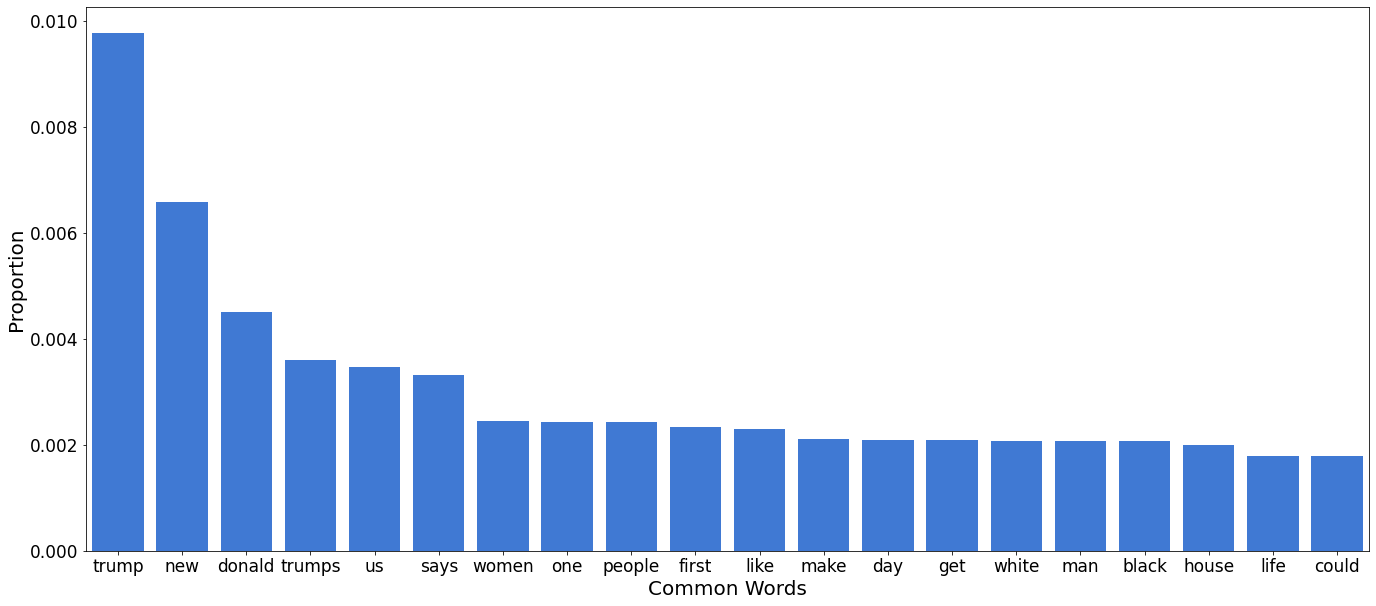

In [26]:
plt.figure(figsize=(23,10))

sns.barplot(x = 'common_words',
            y = 'count_pc',
            data = cw_r,
            color="#2873eb")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_real_count_pc_rmsw.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


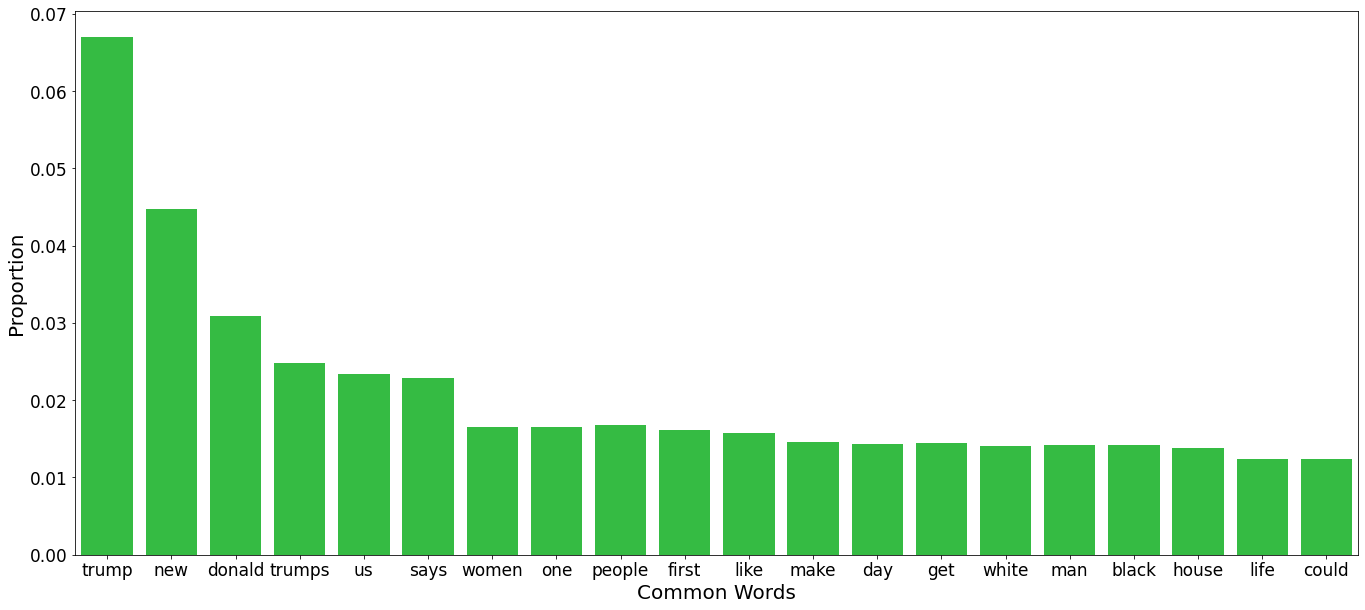

In [27]:
plt.figure(figsize=(23,10))

sns.barplot(x = 'common_words',
            y = 'count_sent_pc',
            data = cw_r,
            color="#1fd131")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_real_count_sent_pc_rmsw.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


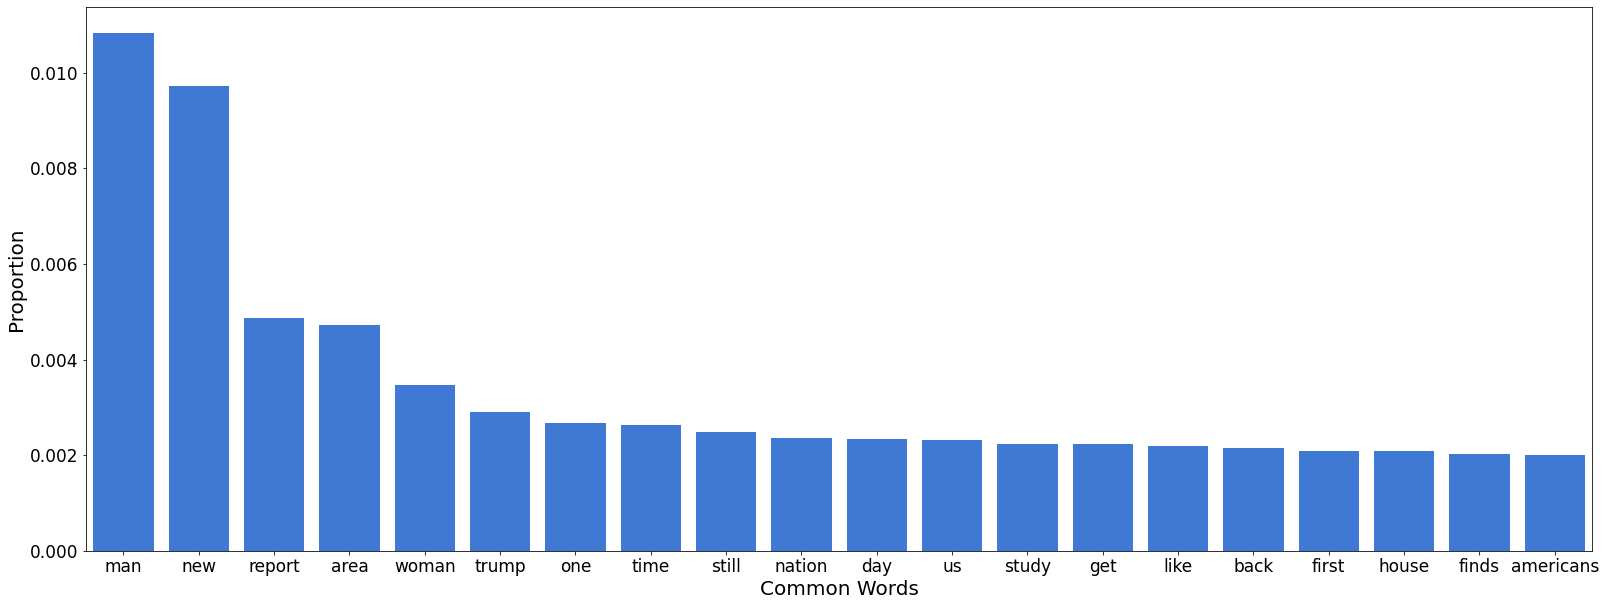

In [28]:
plt.figure(figsize=(27,10))

sns.barplot(x = 'common_words',
            y = 'count_pc',
            data = cw_s,
            color="#2873eb")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_sarcastic_count_pc_rmsw.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


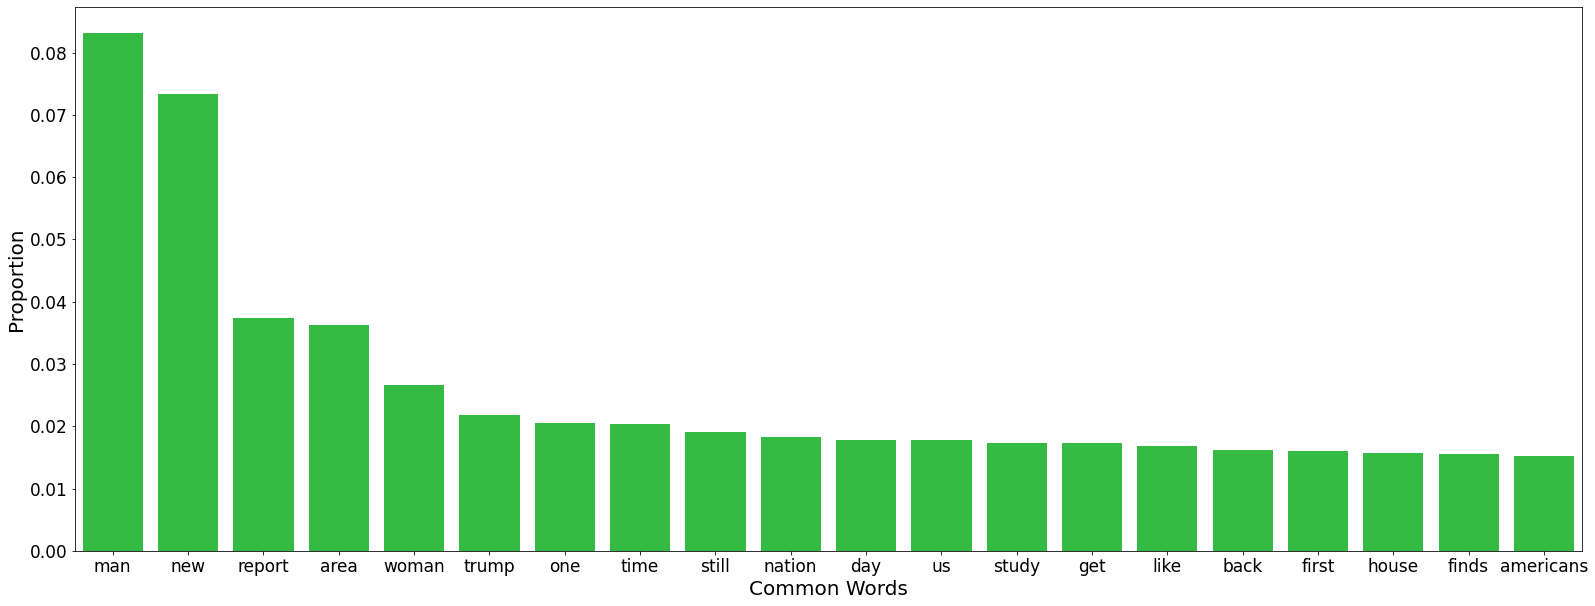

In [29]:
plt.figure(figsize=(27,10))

sns.barplot(x = 'common_words',
            y = 'count_sent_pc',
            data = cw_s,
            color="#1fd131")
plt.xlabel('Common Words', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/common_words_sarcastic_count_sent_pc_rmsw.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()


In [30]:
# Same words in the top 20 common words in 2 classes
[x for x in list_common_words_real[0:20] if x in list_common_words_sarcastic[0:20]]

['trump', 'new', 'us', 'one', 'first', 'like', 'day', 'get', 'man', 'house']

# Length Headline
Length of headline (number of words) of 2 classes and plot the distribution each

In [31]:
# Remove symbol and perform EDA on this preprocessed headline
# count number of words in a headline
data_train_eda = data_train.copy()
data_train_eda['len_headline'] = data_train_eda.headline_s1.apply(lambda row: count_word(row)) # count words in title
print(f"Correlation with label: {data_train_eda['len_headline'].corr(data_train_eda['is_sarcastic'])}")

Correlation with label: 0.0644735193347528


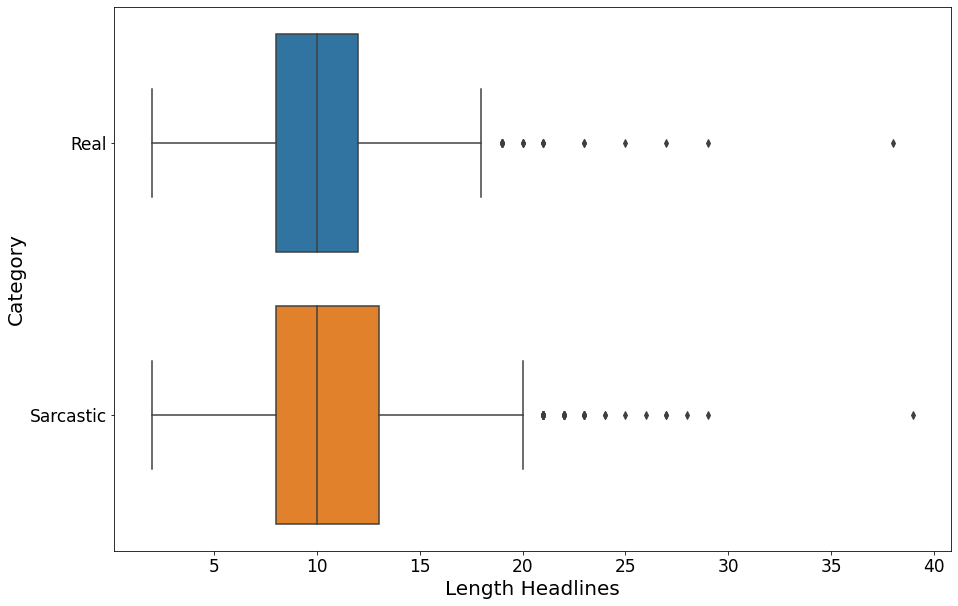

In [32]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="len_headline", data=data_train_eda, orient="h")
plt.xlabel('Length Headlines', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/length_headlines.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# Discard Symbol
count the ratio of symbol in a sentence of 2 classes and plot the distribution each

In [34]:
# Calculate the symbol and number of character in a headline --> calculate ratio
data_train_eda['headline_s1'] = data_train_eda.headline.apply(lambda row: remove_symbol(row))
data_train_eda['len_char_s1'] = data_train_eda.headline_s1.apply(lambda row: len(row))
data_train_eda['len_char_headline'] = data_train_eda.headline.apply(lambda row: len(row))
data_train_eda['count_symbol'] = data_train_eda.len_char_headline - data_train_eda.len_char_s1
data_train_eda['count_symbol_norm'] = data_train_eda.count_symbol / data_train_eda.len_char_headline
print(f"Correlation with label: {data_train_eda['count_symbol_norm'].corr(data_train_eda['is_sarcastic'])}")

Correlation with label: -0.16538741712371963


In [35]:
data_temp = data_train_eda.groupby(['is_sarcastic'])['count_symbol_norm'].describe().reset_index()
data_temp

,is_sarcastic,count,mean,std,min,25%,50%,75%,max
0,0,8991.0,0.021444,0.023085,0.0,0.0,0.016393,0.033521,0.272727
1,1,8180.0,0.014326,0.018918,0.0,0.0,0.009709,0.022727,0.190476


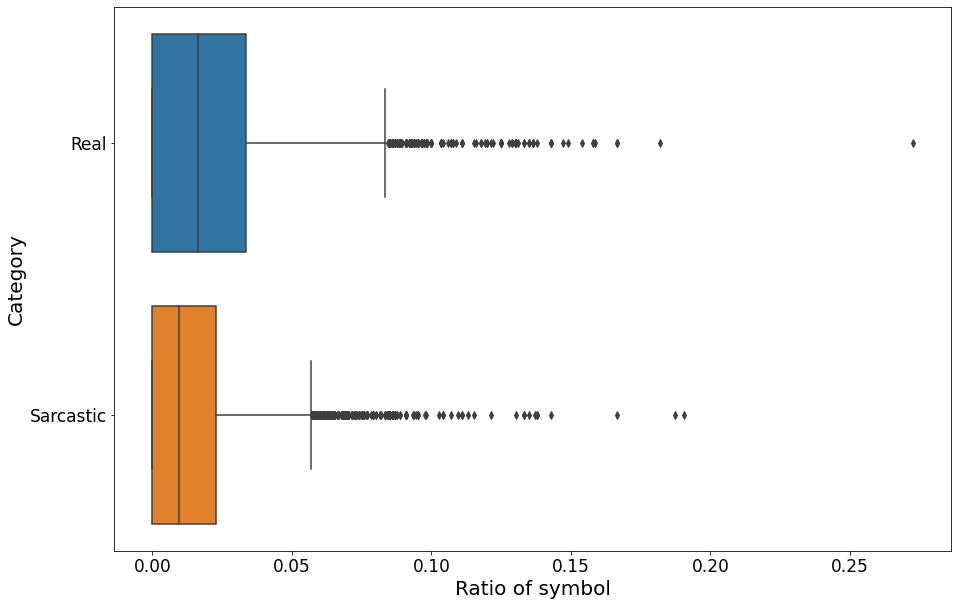

In [36]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="count_symbol_norm", data=data_train_eda, orient="h")
plt.xlabel('Ratio of symbol', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/ratio_symbol.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# Lemmatised word
Perform lemmatising words and count the ratio of lemmatised word in a sentence

In [37]:
# count the number of lemmatised word
data_train_eda['len_headline_s2'] = data_train_eda.headline_s2.apply(lambda row: count_word(row))
count_lemmatized = count_lemmatized_word(data_train_eda, 'headline_s1', 'headline_s2')

In [38]:
data_train_eda['count_lemmatized'] = count_lemmatized
data_train_eda['ratio_lemmatized'] = data_train_eda['count_lemmatized'] / data_train_eda['len_headline_s2']

In [39]:
print(f"Correlation with label: {data_train_eda['ratio_lemmatized'].corr(data_train_eda['is_sarcastic'])}")
data_temp = data_train_eda.groupby(['is_sarcastic'])['ratio_lemmatized'].describe().reset_index()
data_temp

Correlation with label: 0.0778463808884085


,is_sarcastic,count,mean,std,min,25%,50%,75%,max
0,0,8991.0,0.205522,0.127412,0.0,0.111111,0.200000,0.285714,1.0
1,1,8180.0,0.224686,0.117042,0.0,0.142857,0.214286,0.285714,1.0


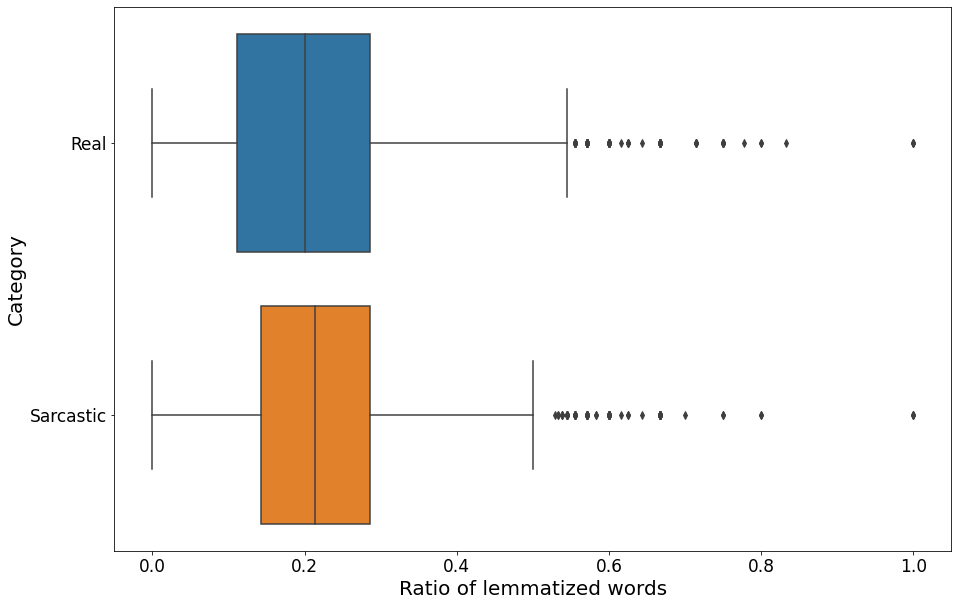

In [40]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="ratio_lemmatized", data=data_train_eda, orient="h")
plt.xlabel('Ratio of lemmatized words', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/ratio_lemmatized.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# Remove Stopwords
Calculate the ratio of stop words in a headline of each class

In [41]:
# Remove stopwords and calculate the number of them to find the ratio
data_train_eda['headline_s3'] = data_train_eda.headline_s2.apply(lambda row: remove_stop_words(row))
data_train_eda['len_headline_s3'] = data_train_eda.headline_s3.apply(lambda row: count_word(row))
data_train_eda['numb_stopwords'] = data_train_eda['len_headline_s2'] - data_train_eda['len_headline_s3']
data_train_eda['ratio_stopwords'] = data_train_eda['numb_stopwords'] / data_train_eda['len_headline_s2']
print(f"Correlation with label: {data_train_eda['ratio_stopwords'].corr(data_train_eda['is_sarcastic'])}")

Correlation with label: -0.21676151959351989


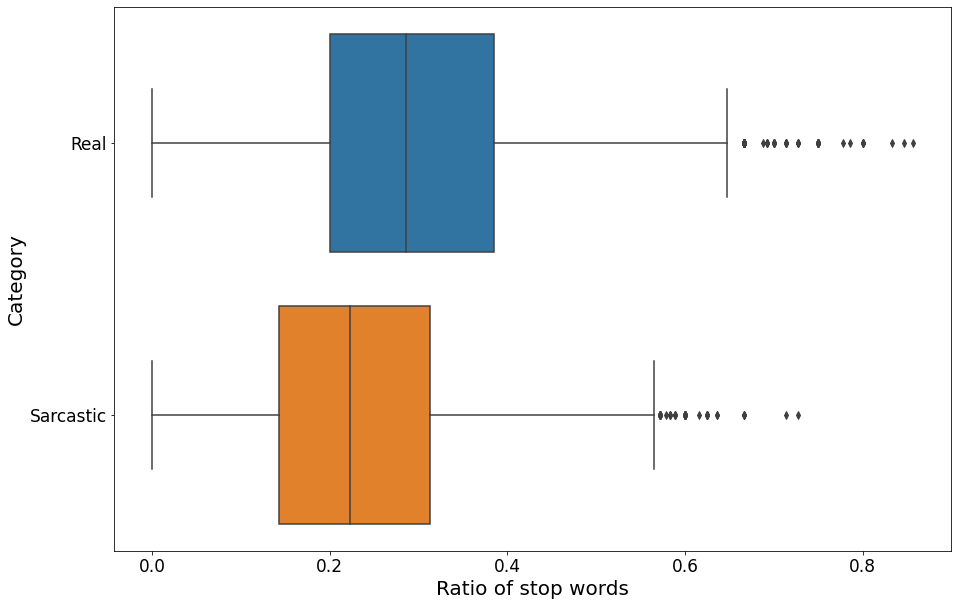

In [42]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="ratio_stopwords", data=data_train_eda, orient="h")
plt.xlabel('Ratio of stop words', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/ratio_stopwords.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# Len of each word in titles
Summary the length of each word (number of character of a word) in a sentence of 2 class. Only perform on sentence that were removed symbol

In [45]:
# min, max, avg length of a word in a headline
data_train_eda['min_len_word_s1'] = data_train_eda.headline_s1.apply(lambda row: min_len_word(row))
data_train_eda['max_len_word_s1'] = data_train_eda.headline_s1.apply(lambda row: max_len_word(row))
data_train_eda['avg_len_word_s1'] = data_train_eda.headline_s1.apply(lambda row: avg_len_word(row))

# data_train_eda['min_len_word_s2'] = data_train_eda.headline_s2.apply(lambda row: min_len_word(row))
# data_train_eda['max_len_word_s2'] = data_train_eda.headline_s2.apply(lambda row: max_len_word(row))
# data_train_eda['avg_len_word_s2'] = data_train_eda.headline_s2.apply(lambda row: avg_len_word(row))

# data_train_eda['min_len_word_s3'] = data_train_eda.headline_s3.apply(lambda row: min_len_word(row))
# data_train_eda['max_len_word_s3'] = data_train_eda.headline_s3.apply(lambda row: max_len_word(row))
# data_train_eda['avg_len_word_s3'] = data_train_eda.headline_s3.apply(lambda row: avg_len_word(row))

In [46]:
print(f"min_len_word_s1: {data_train_eda['min_len_word_s1'].corr(data_train_eda['is_sarcastic'])}")
print(f"max_len_word_s1: {data_train_eda['max_len_word_s1'].corr(data_train_eda['is_sarcastic'])}")
print(f"avg_len_word_s1: {data_train_eda['avg_len_word_s1'].corr(data_train_eda['is_sarcastic'])}")

# print(f"min_len_word_s2: {data_train_eda['min_len_word_s2'].corr(data_train_eda['is_sarcastic'])}")
# print(f"max_len_word_s2: {data_train_eda['max_len_word_s2'].corr(data_train_eda['is_sarcastic'])}")
# print(f"avg_len_word_s2: {data_train_eda['avg_len_word_s2'].corr(data_train_eda['is_sarcastic'])}")

# print(f"min_len_word_s3: {data_train_eda['min_len_word_s3'].corr(data_train_eda['is_sarcastic'])}")
# print(f"max_len_word_s3: {data_train_eda['max_len_word_s3'].corr(data_train_eda['is_sarcastic'])}")
# print(f"avg_len_word_s3: {data_train_eda['avg_len_word_s3'].corr(data_train_eda['is_sarcastic'])}")

min_len_word_s1: 0.12809436787259382
max_len_word_s1: 0.10125532224542759
avg_len_word_s1: 0.17644322136342283


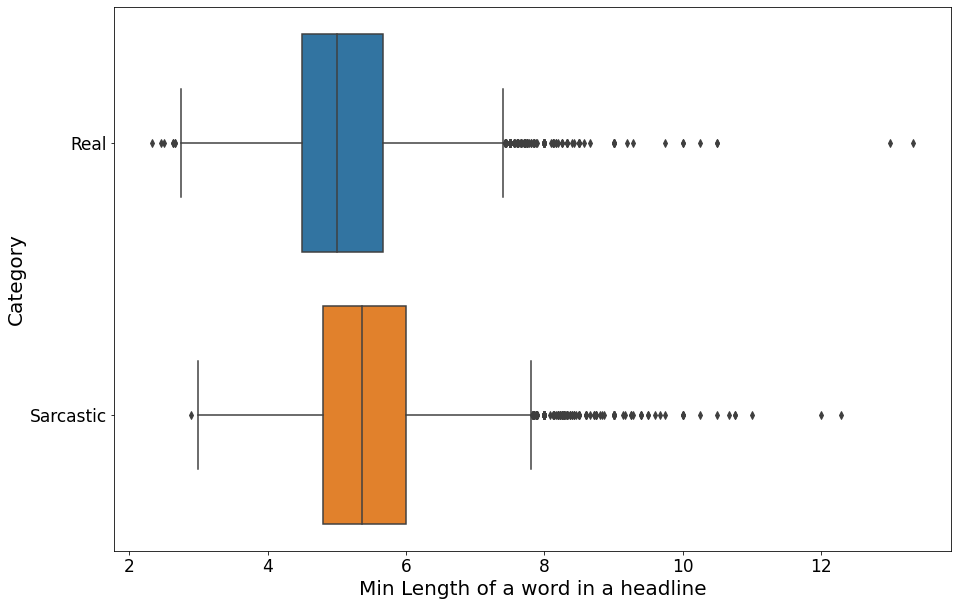

In [47]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="avg_len_word_s1", data=data_train_eda, orient="h")
plt.xlabel('Min Length of a word in a headline', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/avg_len_word.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# Syllable
Calculate the number of syllable in a word of a headline. Since the boxplot in this case is hard to see, I did not plot it here

In [48]:
# Count min, max, avg of syllable of a word in a headline
# Since longer sentences have more number of syllable --> normalise by divided by the length of a sentence
data_train_eda['min_syl_word'] = data_train_eda.headline_s1.apply(lambda row: min_syl_word(row))
data_train_eda['max_syl_word'] = data_train_eda.headline_s1.apply(lambda row: max_syl_word(row))
data_train_eda['avg_syl_word'] = data_train_eda.headline_s1.apply(lambda row: avg_syl_word(row))
data_train_eda['numb_syl'] = data_train_eda.headline_s1.apply(lambda row: count_syllable(row))
data_train_eda['norm_numb_syl'] = data_train_eda.numb_syl / data_train_eda.len_headline_s2

In [49]:
print(f"min_syl_word_s1: {data_train_eda['min_syl_word'].corr(data_train_eda['is_sarcastic'])}")
print(f"max_syl_word_s1: {data_train_eda['max_syl_word'].corr(data_train_eda['is_sarcastic'])}")
print(f"avg_syl_word_s1: {data_train_eda['avg_syl_word'].corr(data_train_eda['is_sarcastic'])}")
print(f"norm_numb_syl: {data_train_eda['norm_numb_syl'].corr(data_train_eda['is_sarcastic'])}")

min_syl_word_s1: 0.01864376252850398
max_syl_word_s1: 0.08684631505379782
avg_syl_word_s1: 0.15273361588747364
norm_numb_syl: 0.14941247047380204


# Readability test
Calculate readability score based on a headline

In [50]:
# Calculate 6 test
data_train_eda['flesch_grade_score'] = data_train_eda.headline.apply(lambda row: textstat.flesch_kincaid_grade(row))
data_train_eda['ari_score'] = data_train_eda.headline.apply(lambda row: textstat.automated_readability_index(row))
data_train_eda['coleman_score'] = data_train_eda.headline.apply(lambda row: textstat.coleman_liau_index(row))
data_train_eda['linsear_score'] = data_train_eda.headline.apply(lambda row: textstat.linsear_write_formula(row))
data_train_eda['dale_score'] = data_train_eda.headline.apply(lambda row: textstat.dale_chall_readability_score(row))
data_train_eda['standard_score'] = data_train_eda.headline.apply(lambda row: textstat.text_standard(row, float_output=True))

In [51]:
print(f"flesch_grade_score: {data_train_eda['flesch_grade_score'].corr(data_train_eda['is_sarcastic'])}") # choose
print(f"ari_score: {data_train_eda['ari_score'].corr(data_train_eda['is_sarcastic'])}") # choose
print(f"coleman_score: {data_train_eda['coleman_score'].corr(data_train_eda['is_sarcastic'])}") # choose
print(f"linsear_score: {data_train_eda['linsear_score'].corr(data_train_eda['is_sarcastic'])}") # choose
print(f"dale_score: {data_train_eda['dale_score'].corr(data_train_eda['is_sarcastic'])}") # choose
print(f"standard_score: {data_train_eda['standard_score'].corr(data_train_eda['is_sarcastic'])}") # choose

flesch_grade_score: 0.17272895476907507
ari_score: 0.18373155948391828
coleman_score: 0.18861258025918873
linsear_score: 0.11779905220878273
dale_score: 0.10409109272528452
standard_score: 0.13244296084331283


In [52]:
data_temp = data_train_eda.groupby(['is_sarcastic'])['ari_score'].describe().reset_index()
data_temp

,is_sarcastic,count,mean,std,min,25%,50%,75%,max
0,0,8991.0,8.258125,4.228454,-6.8,5.6,8.1,10.8,49.2
1,1,8180.0,9.876186,4.426212,-5.4,7.0,9.8,12.5,42.9


In [53]:
data_temp = data_train_eda.groupby(['is_sarcastic'])['coleman_score'].describe().reset_index()
data_temp

,is_sarcastic,count,mean,std,min,25%,50%,75%,max
0,0,8991.0,10.538196,5.131837,-13.21,7.245,10.24,13.72,51.75
1,1,8180.0,12.533443,5.250788,-10.31,9.060,12.25,15.74,51.34


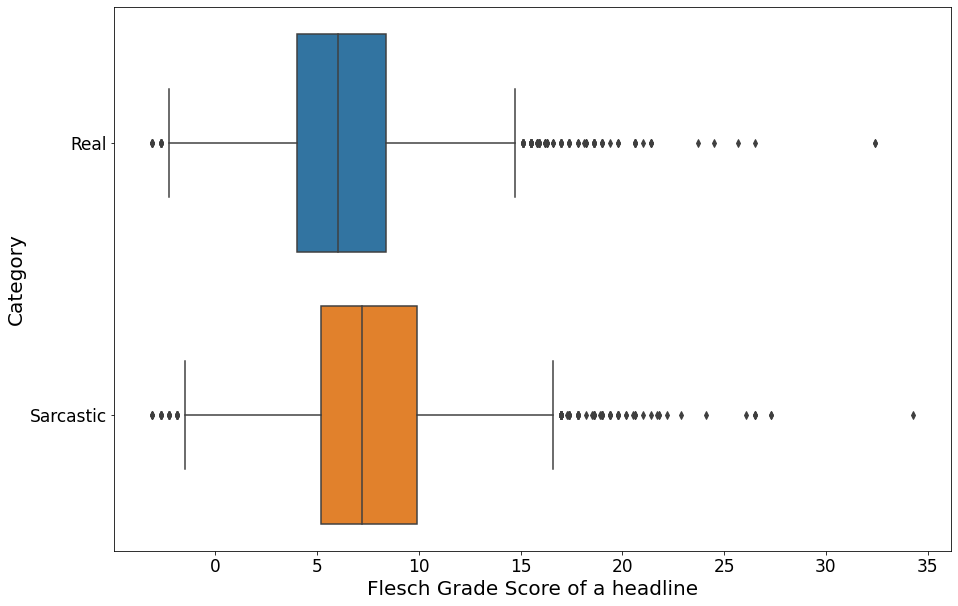

In [54]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="flesch_grade_score", data=data_train_eda, orient="h")
plt.xlabel('Flesch Grade Score of a headline', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/flesch_grade_score.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

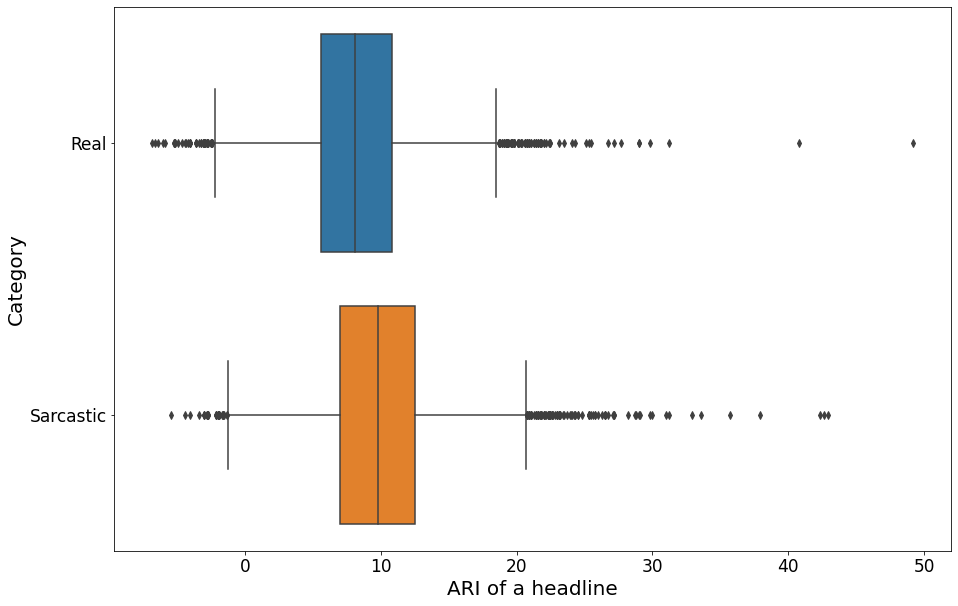

In [55]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="ari_score", data=data_train_eda, orient="h")
plt.xlabel('ARI of a headline', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/ari_score.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

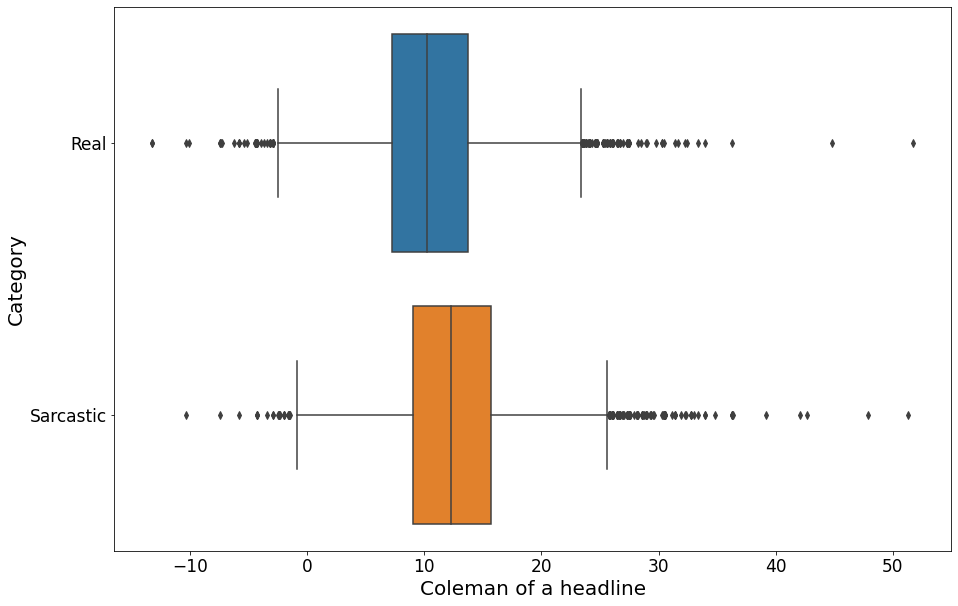

In [56]:
plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="coleman_score", data=data_train_eda, orient="h")
plt.xlabel('Coleman of a headline', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
plt.savefig('../figures/coleman_score.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# POS
Count number of noun, verb, adj, ... (Part-of-speech) in a headline. Since longer sentence tend to have more POS, I normalized by dividing it to the length of the sentence.

In [57]:
data_train_eda['numb_NN'] = data_train_eda.headline.apply(lambda row: count_noun(row))
data_train_eda['numb_VED'] = data_train_eda.headline.apply(lambda row: count_verb_past(row))
data_train_eda['numb_VB'] = data_train_eda.headline.apply(lambda row: count_verb_present(row))
data_train_eda['numb_VING'] = data_train_eda.headline.apply(lambda row: count_verb_ing(row))
data_train_eda['numb_ADJ'] = data_train_eda.headline.apply(lambda row: count_adj(row))
data_train_eda['numb_ADV'] = data_train_eda.headline.apply(lambda row: count_adv(row))
data_train_eda['numb_DT'] = data_train_eda.headline.apply(lambda row: count_DT(row))
data_train_eda['numb_CD'] = data_train_eda.headline.apply(lambda row: count_CD(row))
data_train_eda['numb_PR'] = data_train_eda.headline.apply(lambda row: count_pronoun(row))

data_train_eda['norm_numb_NN'] = data_train_eda['numb_NN'] / data_train_eda['len_headline']
data_train_eda['norm_numb_VED'] = data_train_eda['numb_VED'] / data_train_eda['len_headline']
data_train_eda['norm_numb_VB'] = data_train_eda['numb_VB'] / data_train_eda['len_headline']
data_train_eda['norm_numb_VING'] = data_train_eda['numb_VING'] / data_train_eda['len_headline']
data_train_eda['norm_numb_ADJ'] = data_train_eda['numb_ADJ'] / data_train_eda['len_headline']
data_train_eda['norm_numb_ADV'] = data_train_eda['numb_ADV'] / data_train_eda['len_headline']
data_train_eda['norm_numb_DT'] = data_train_eda['numb_DT'] / data_train_eda['len_headline']
data_train_eda['norm_numb_CD'] = data_train_eda['numb_CD'] / data_train_eda['len_headline']
data_train_eda['norm_numb_PR'] = data_train_eda['numb_PR'] / data_train_eda['len_headline']

In [58]:
print(f"norm_numb_NN: {data_train_eda['norm_numb_NN'].corr(data_train_eda['is_sarcastic'])}")
print(f"norm_numb_VED: {data_train_eda['norm_numb_VED'].corr(data_train_eda['is_sarcastic'])}") # Choose
print(f"norm_numb_VB: {data_train_eda['numb_VB'].corr(data_train_eda['is_sarcastic'])}")
print(f"norm_numb_VING: {data_train_eda['norm_numb_VING'].corr(data_train_eda['is_sarcastic'])}")# Choose
print(f"norm_numb_ADJ: {data_train_eda['norm_numb_ADJ'].corr(data_train_eda['is_sarcastic'])}")# Choose
print(f"norm_numb_ADV: {data_train_eda['norm_numb_ADV'].corr(data_train_eda['is_sarcastic'])}")# Choose
print(f"norm_numb_DT: {data_train_eda['norm_numb_DT'].corr(data_train_eda['is_sarcastic'])}")# Choose
print(f"norm_numb_CD: {data_train_eda['norm_numb_CD'].corr(data_train_eda['is_sarcastic'])}")
print(f"norm_numb_PR: {data_train_eda['norm_numb_PR'].corr(data_train_eda['is_sarcastic'])}")# Choose

norm_numb_NN: 0.017673809736080133
norm_numb_VED: 0.10854015493307353
norm_numb_VB: -0.03223488854882539
norm_numb_VING: 0.11412038856995074
norm_numb_ADJ: 0.11984050446101263
norm_numb_ADV: 0.12619722292026433
norm_numb_DT: -0.31951583530351824
norm_numb_CD: -0.04974062093084661
norm_numb_PR: -0.11267147565211466


In [59]:
data_temp = data_train_eda.groupby(['is_sarcastic'])['norm_numb_DT'].describe().reset_index()
data_temp

,is_sarcastic,count,mean,std,min,25%,50%,75%,max
0,0,8991.0,0.062187,0.077896,0.0,0.0,0.0,0.111111,0.5
1,1,8180.0,0.018865,0.044440,0.0,0.0,0.0,0.000000,0.4


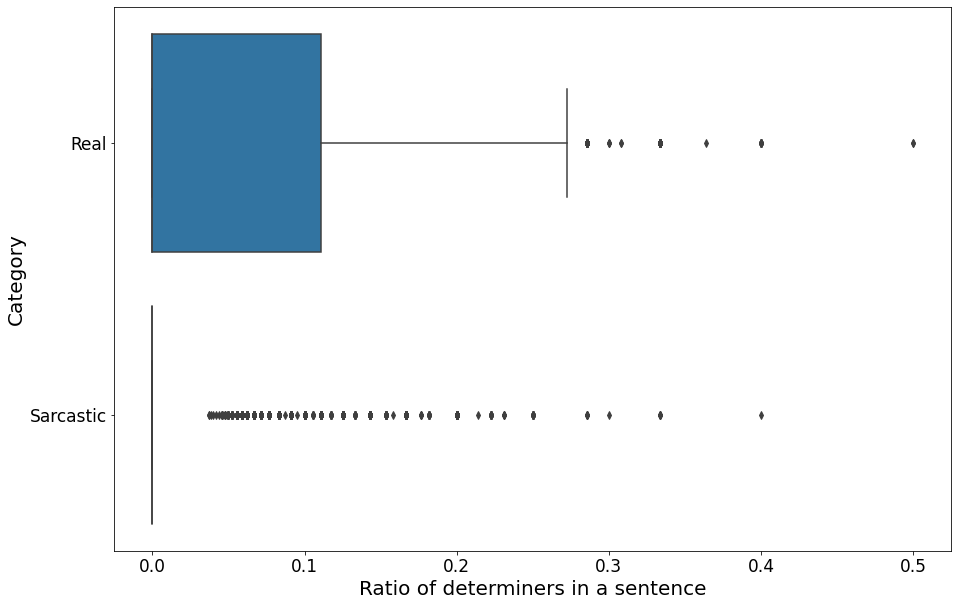

In [60]:
# Although it is hard to interprete this plot,
# but can see that Real headlines tend to have more determiners in the sentences

plt.figure(figsize=(15,10))

sns.boxplot(y="is_sarcastic", x="norm_numb_DT", data=data_train_eda, orient="h")
plt.xlabel('Ratio of determiners in a sentence', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.yticks(np.arange(2), ('Real', 'Sarcastic'))
# plt.savefig('../figures/coleman_score.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

# Feature Selection
Run again all above steps to calculate correlation to each other as well as correlation to the target variable to select features in a basic protocol. I also plot the correlation matrix.

In [10]:
# Run all again
data_train_eda = data_train.copy()
data_train_eda['len_headline'] = data_train_eda.headline_s1.apply(lambda row: count_word(row)) # count words in title

data_train_eda['len_char_s1'] = data_train_eda.headline_s1.apply(lambda row: len(row))
data_train_eda['len_char_headline'] = data_train_eda.headline.apply(lambda row: len(row))
data_train_eda['count_symbol'] = data_train_eda.len_char_headline - data_train_eda.len_char_s1
data_train_eda['count_symbol_norm'] = data_train_eda.count_symbol / data_train_eda.len_char_headline

data_train_eda['len_headline_s2'] = data_train_eda.headline_s2.apply(lambda row: count_word(row))
count_lemmatized = count_lemmatized_word(data_train_eda, 'headline_s1', 'headline_s2')
data_train_eda['count_lemmatized'] = count_lemmatized
data_train_eda['ratio_lemmatized'] = data_train_eda['count_lemmatized'] / data_train_eda['len_headline_s2']

data_train_eda['headline_s3'] = data_train_eda.headline_s2.apply(lambda row: remove_stop_words(row))
data_train_eda['len_headline_s3'] = data_train_eda.headline_s3.apply(lambda row: count_word(row))
data_train_eda['numb_stopwords'] = data_train_eda['len_headline_s2'] - data_train_eda['len_headline_s3']
data_train_eda['ratio_stopwords'] = data_train_eda['numb_stopwords'] / data_train_eda['len_headline_s2']

data_train_eda['min_len_word_s1'] = data_train_eda.headline_s1.apply(lambda row: min_len_word(row))
data_train_eda['max_len_word_s1'] = data_train_eda.headline_s1.apply(lambda row: max_len_word(row))
data_train_eda['avg_len_word_s1'] = data_train_eda.headline_s1.apply(lambda row: avg_len_word(row))

data_train_eda['max_syl_word'] = data_train_eda.headline_s1.apply(lambda row: max_syl_word(row))
data_train_eda['avg_syl_word'] = data_train_eda.headline_s1.apply(lambda row: avg_syl_word(row))
data_train_eda['numb_syl'] = data_train_eda.headline_s1.apply(lambda row: count_syllable(row))
data_train_eda['norm_numb_syl'] = data_train_eda.numb_syl / data_train_eda.len_headline_s2

data_train_eda['flesch_grade_score'] = data_train_eda.headline.apply(lambda row: textstat.flesch_kincaid_grade(row))
data_train_eda['ari_score'] = data_train_eda.headline.apply(lambda row: textstat.automated_readability_index(row))
data_train_eda['coleman_score'] = data_train_eda.headline.apply(lambda row: textstat.coleman_liau_index(row))
data_train_eda['linsear_score'] = data_train_eda.headline.apply(lambda row: textstat.linsear_write_formula(row))
data_train_eda['dale_score'] = data_train_eda.headline.apply(lambda row: textstat.dale_chall_readability_score(row))
data_train_eda['standard_score'] = data_train_eda.headline.apply(lambda row: textstat.text_standard(row, float_output=True))

data_train_eda['numb_NN'] = data_train_eda.headline.apply(lambda row: count_noun(row))
data_train_eda['numb_VED'] = data_train_eda.headline.apply(lambda row: count_verb_past(row))
data_train_eda['numb_VB'] = data_train_eda.headline.apply(lambda row: count_verb_present(row))
data_train_eda['numb_VING'] = data_train_eda.headline.apply(lambda row: count_verb_ing(row))
data_train_eda['numb_ADJ'] = data_train_eda.headline.apply(lambda row: count_adj(row))
data_train_eda['numb_ADV'] = data_train_eda.headline.apply(lambda row: count_adv(row))
data_train_eda['numb_DT'] = data_train_eda.headline.apply(lambda row: count_DT(row))
data_train_eda['numb_CD'] = data_train_eda.headline.apply(lambda row: count_CD(row))
data_train_eda['numb_PR'] = data_train_eda.headline.apply(lambda row: count_pronoun(row))

data_train_eda['norm_numb_NN'] = data_train_eda['numb_NN'] / data_train_eda['len_headline']
data_train_eda['norm_numb_VED'] = data_train_eda['numb_VED'] / data_train_eda['len_headline']
data_train_eda['norm_numb_VB'] = data_train_eda['numb_VB'] / data_train_eda['len_headline']
data_train_eda['norm_numb_VING'] = data_train_eda['numb_VING'] / data_train_eda['len_headline']
data_train_eda['norm_numb_ADJ'] = data_train_eda['numb_ADJ'] / data_train_eda['len_headline']
data_train_eda['norm_numb_ADV'] = data_train_eda['numb_ADV'] / data_train_eda['len_headline']
data_train_eda['norm_numb_DT'] = data_train_eda['numb_DT'] / data_train_eda['len_headline']
data_train_eda['norm_numb_CD'] = data_train_eda['numb_CD'] / data_train_eda['len_headline']
data_train_eda['norm_numb_PR'] = data_train_eda['numb_PR'] / data_train_eda['len_headline']

In [61]:
# Remove columns not to use
# For exp: some number features will not used as we have normalised number and we use them instead
data_train_ft = data_train_eda.drop(columns=['numb_syl', 'count_symbol', 'len_char_s1', 'len_char_headline',
                             'count_lemmatized', 'len_headline_s2', 'len_headline_s3', 'numb_stopwords', 
                             'headline_s1', 'headline_s2', 'headline_s3', 'numb_NN', 'numb_VED', 
                             'numb_VB', 'numb_VING', 'numb_ADJ', 'numb_ADV', 'numb_DT', 'numb_CD', 'numb_PR',
                             'headline'])
data_train_ft.head()

,is_sarcastic,len_headline,count_symbol_norm,ratio_lemmatized,ratio_stopwords,min_len_word_s1,max_len_word_s1,avg_len_word_s1,min_syl_word,max_syl_word,...,standard_score,norm_numb_NN,norm_numb_VED,norm_numb_VB,norm_numb_VING,norm_numb_ADJ,norm_numb_ADV,norm_numb_DT,norm_numb_CD,norm_numb_PR
0,0,3,0.111111,0.000000,0.333333,4,5,4.666667,1,2,...,1.0,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.333333
1,1,15,0.020000,0.133333,0.266667,2,9,5.600000,1,3,...,12.0,0.333333,0.000000,0.133333,0.066667,0.200000,0.066667,0.066667,0.0,0.066667
2,1,12,0.013514,0.333333,0.250000,2,10,5.166667,1,3,...,6.0,0.333333,0.083333,0.000000,0.000000,0.500000,0.083333,0.000000,0.0,0.000000
3,0,8,0.022222,0.250000,0.375000,2,9,4.625000,1,3,...,5.0,0.625000,0.125000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000
4,1,11,0.016667,0.181818,0.363636,2,9,4.454545,1,3,...,6.0,0.272727,0.000000,0.272727,0.000000,0.181818,0.090909,0.000000,0.0,0.090909


In [67]:
# Remove some features with low correlation with output or high correlation with other features
data_train_ft = data_train_ft.drop(columns=['norm_numb_syl']) # high correlation with avg_syl
data_train_ft = data_train_ft.drop(columns=['min_syl_word']) # low correlation with label

In [68]:
# Plot correlation matrix
corrMatrix = data_train_ft.corr()
for col in list(corrMatrix.keys()):
    corrMatrix[col] = corrMatrix[col].apply(lambda row: round(row, 2))

In [69]:
corrMatrix.iloc[:,10:20]

,flesch_grade_score,ari_score,coleman_score,linsear_score,dale_score,standard_score,norm_numb_NN,norm_numb_VED,norm_numb_VB,norm_numb_VING
is_sarcastic,0.17,0.18,0.19,0.12,0.10,0.13,0.02,0.11,-0.05,0.11
len_headline,0.12,0.06,-0.06,0.86,-0.09,0.14,-0.24,-0.00,0.09,0.02
count_symbol_norm,-0.09,0.08,-0.06,-0.08,-0.07,-0.07,0.04,-0.05,0.07,-0.09
ratio_lemmatized,0.14,0.24,0.25,-0.01,0.22,0.13,0.08,0.23,-0.02,0.35
ratio_stopwords,-0.32,-0.49,-0.52,0.15,-0.41,-0.27,-0.51,-0.01,0.12,-0.03
min_len_word_s1,0.19,0.38,0.39,-0.29,0.24,0.14,0.26,0.05,-0.06,0.08
max_len_word_s1,0.59,0.66,0.66,0.31,0.42,0.53,0.07,-0.01,-0.08,0.04
avg_len_word_s1,0.74,0.93,0.96,0.04,0.69,0.63,0.32,0.04,-0.17,0.14
max_syl_word,0.71,0.54,0.55,0.41,0.43,0.64,0.04,-0.00,-0.08,0.05
avg_syl_word,0.93,0.77,0.81,0.19,0.74,0.78,0.21,0.02,-0.16,0.15


In [70]:
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

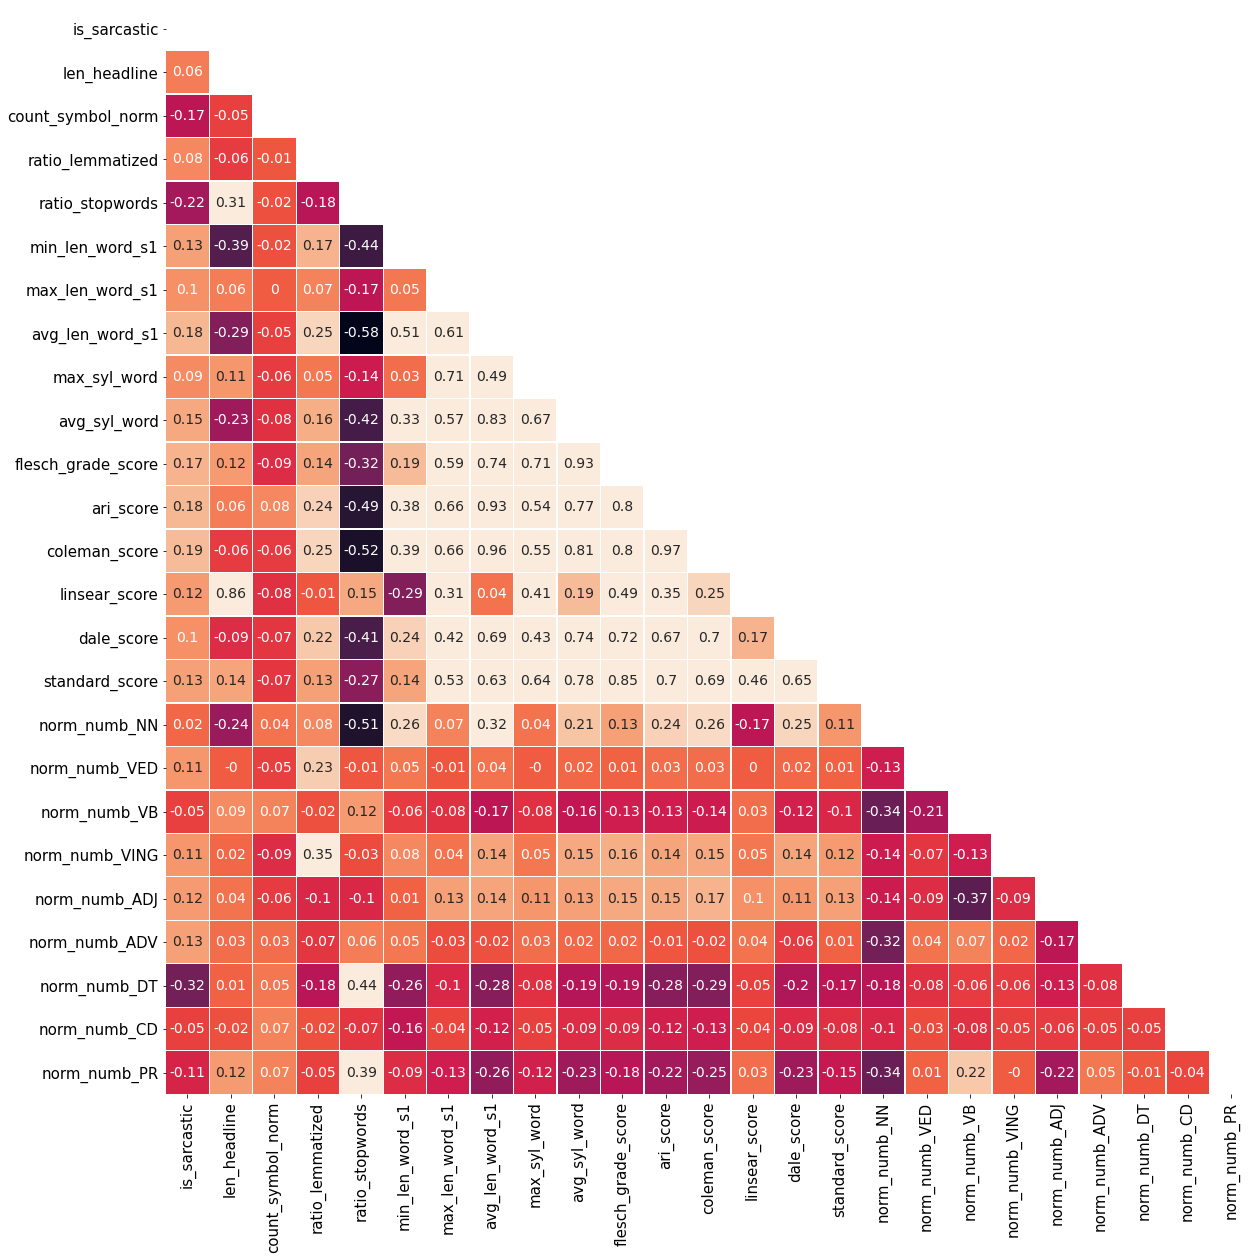

In [73]:
#with sns.axes_style("white"):
plt.figure(figsize=(20,20))
ax = sns.heatmap(corrMatrix, mask=mask, vmax=.3, square=True, annot=True, 
                 cbar=False, annot_kws={"size":14}, linewidths=.25)
# plt.xlabel('Ratio of symbol', fontsize=20)
# plt.ylabel('Category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../figures/corr_mat.png', bbox_inches='tight', transparent=False, dpi=400)
plt.show()